# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Clustering](#Clustering)
    - [4-Seam](#4-Seam-Fastball)
    - [Cutter](#Cutter)
    - [Sinker](#Sinker)
    - [Slider](#Slider)
    - [Curveball](#Curveball)
    - [Changeup](#Changeup)
- [Linear Regression Modeling](#Linear-Regression-Modeling)
    - [4-Seam](#Linear-Regression---4-Seam)
    - [Cutter](#Linear-Regression---Cutter)
    - [Sinker](#Linear-Regression---Sinker)
    - [Slider](#Linear-Regression---Slider)
    - [Curveball](#Linear-Regression---Curveball)
    - [Changeup](#Linear-Regression---Changeup)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(116889, 30)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,swing_miss,delta_run_exp,stand,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,xba,xwobacon,woba_value,woba_denom,babip_value,iso_value
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,0,-0.073,R,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,0,-0.189,L,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0
9,"Gsellman, Robert",R,SI,94.3,1982.0,221.0,16.20,10.56,21.018028,94.4,-1.20,6.05,6.5,53.98,0.26,-0.26,1.78,0,-0.061,R,140.0,75.3,65.0,3.0,0.000,0.000,0.0,1.0,0.0,0.0
18,"Gsellman, Robert",R,SL,90.5,2133.0,216.0,-0.12,7.44,23.569061,91.1,-1.51,5.93,6.3,54.23,-0.01,0.01,2.23,0,-0.173,L,294.0,96.8,18.0,4.0,0.409,0.457,0.0,1.0,0.0,0.0
27,"Martin, Chris",R,FF,94.9,2224.0,216.0,9.00,14.16,23.435195,95.5,-2.71,6.38,6.6,53.86,0.10,-0.10,1.94,0,-0.163,R,308.0,91.8,29.0,3.0,0.109,0.156,0.0,1.0,0.0,0.0


In [3]:
# data['stand'] = data['stand'].map({'R': 0, 'L': 1})
# data['p_throws'] = data['p_throws'].map({'R': 0, 'L': 1})

# Drop pitch types Knuckle Curve and Splitter
# pitch = pitch[(pitch['pitch_type'] != 'KC') & (pitch['pitch_type'] != 'FS')]

Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

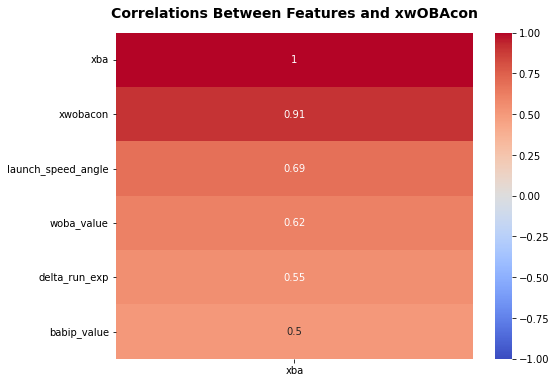

In [4]:
plt.figure(figsize = (8, 6))
sns.heatmap(data.corr()[['xba']][data.corr()['xba'] > .5].sort_values('xba', ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlations Between Features and xwOBAcon', fontsize = 14, fontweight = 'bold', pad = 15);

### Multicolinearity - VIF

In [5]:
features = data[['velo', 'release_extension', 'pfx_-x', 
                 'pfx_z', 'release_pos_z','launch_speed_angle',
                 'xba', 'pitch_type', 'p_throws']]
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(10)

,feature,VIF
2,pfx_-x,1.095283
3,pfx_z,2.718061
6,xba,4.277034
5,launch_speed_angle,13.293887
4,release_pos_z,97.124627
1,release_extension,151.328536
0,velo,221.930367


# Features

**Independent Variables:** Velocity, VB, HB, Release Extension, Vertical Release Position, Launch Speed Angle

**Dependent Variable:** xBA

In [6]:
ff = features.loc[features['pitch_type'] == 'FF']
print('4-Seam shape:', ff.shape)
ff_r = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'R')]
print('RHP 4-Seam shape:', ff_r.shape)
ff_l = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'L')]
print('LHP 4-Seam shape:', ff_l.shape, '\n')
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
fc_r = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'R')]
print('RHP Cutter shape:', fc_r.shape)
fc_l = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'L')]
print('LHP Cutter shape:', fc_l.shape, '\n')
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
si_r = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'R')]
print('RHP Sinker shape:', si_r.shape)
si_l = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'L')]
print('LHP Sinker shape:', si_l.shape, '\n')
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
sl_r = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'R')]
print('RHP Slider shape:', sl_r.shape)
sl_l = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'L')]
print('LHP Slider shape:', sl_l.shape, '\n')
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
cu_r = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'R')]
print('RHP Curveball shape:', cu_r.shape)
cu_l = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'L')]
print('LHP Curveball shape:', cu_l.shape, '\n')
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)
ch_r = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'R')]
print('RHP Changeup shape:', ch_r.shape)
ch_l = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'L')]
print('LHP Changeup shape:', ch_l.shape)

4-Seam shape: (40378, 9)
RHP 4-Seam shape: (28478, 9)
LHP 4-Seam shape: (11900, 9) 

Cutter shape: (8698, 9)
RHP Cutter shape: (5588, 9)
LHP Cutter shape: (3110, 9) 

Sinker shape: (21979, 9)
RHP Sinker shape: (15373, 9)
LHP Sinker shape: (6606, 9) 

Slider shape: (21518, 9)
RHP Slider shape: (16153, 9)
LHP Slider shape: (5365, 9) 

Curveball shape: (8439, 9)
RHP Curveball shape: (5743, 9)
LHP Curveball shape: (2696, 9) 

Changeup shape: (15877, 9)
RHP Changeup shape: (9626, 9)
LHP Changeup shape: (6251, 9)


# Clustering

## 4-Seam

### RHP

In [7]:
features_ff_r = ff_r.select_dtypes([np.number])
X_ff_r = features_ff_r

ss = StandardScaler()
X_ff_r_scaled = ss.fit_transform(X_ff_r)
X_ff_r_scaled[:,:] *= -1

pca_ff_r = PCA().fit_transform(X_ff_r_scaled)
model_ff_r = pd.DataFrame(data = pca_ff_r, columns = X_ff_r.columns)

km_ff_r = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_r.fit(model_ff_r)
label_ff_r = km_ff_r.fit_predict(model_ff_r)

print('Number of iterations:', km_ff_r.n_iter_)
print('Number of features:', km_ff_r.n_features_in_)
print('Number of clusters:', km_ff_r.n_clusters)
print('Inertia:', km_ff_r.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_r[:10])

Number of iterations: 13
Number of features: 7
Number of clusters: 2
Inertia: 159113.23405257505 

Predicted clusters to points:  [0 0 0 0 0 0 0 1 1 1]


### LHP

In [8]:
features_ff_l = ff_l.select_dtypes([np.number])
X_ff_l = features_ff_l

ss = StandardScaler()
X_ff_l_scaled = ss.fit_transform(X_ff_l)
X_ff_l_scaled[:,:] *= -1

pca_ff_l = PCA().fit_transform(X_ff_l_scaled)
model_ff_l = pd.DataFrame(data = pca_ff_l, columns = X_ff_l.columns)

km_ff_l = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_l.fit(model_ff_l)
label_ff_l = km_ff_l.fit_predict(model_ff_l)

print('Number of iterations:', km_ff_l.n_iter_)
print('Number of features:', km_ff_l.n_features_in_)
print('Number of clusters:', km_ff_l.n_clusters)
print('Inertia:', km_ff_l.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_l[:10])

Number of iterations: 5
Number of features: 7
Number of clusters: 2
Inertia: 66462.53942698044 

Predicted clusters to points:  [1 1 1 1 1 1 1 1 1 0]


### Cluster Labels - RHP 4-Seam

In [9]:
X_ff_r['label'] = label_ff_r
model_ff_r['label'] = label_ff_r

X_ff_r.groupby(by = 'label').mean().T

label,0,1
velo,93.968930,93.964190
release_extension,6.394518,6.387441
pfx_-x,7.074399,7.191133
pfx_z,15.635858,15.701792
release_pos_z,5.877094,5.907502
launch_speed_angle,2.466048,4.675185
xba,0.121758,0.636166


### Cluster Labels - LHP 4-Seam

In [10]:
X_ff_l['label'] = label_ff_l
model_ff_l['label'] = label_ff_l

X_ff_l.groupby(by = 'label').mean().T

label,0,1
velo,92.639170,92.645300
release_extension,6.292309,6.301184
pfx_-x,-7.622589,-7.228755
pfx_z,15.873037,15.734976
release_pos_z,6.015220,5.994530
launch_speed_angle,4.641849,2.426187
xba,0.641461,0.124250


## Cutter

### RHP

In [11]:
features_fc_r = fc_r.select_dtypes([np.number])
X_fc_r = features_fc_r

X_fc_r_scaled = ss.fit_transform(X_fc_r)
X_fc_r_scaled[:,:] *= -1

pca_fc_r = PCA().fit_transform(X_fc_r_scaled)
model_fc_r = pd.DataFrame(data = pca_fc_r, columns = X_fc_r.columns)

km_fc_r = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_r.fit(model_fc_r)
label_fc_r = km_fc_r.fit_predict(model_fc_r)

print('Number of iterations:', km_fc_r.n_iter_)
print('Number of features:', km_fc_r.n_features_in_)
print('Number of clusters:', km_fc_r.n_clusters)
print('Inertia:', km_fc_r.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_r[:10])

Number of iterations: 13
Number of features: 7
Number of clusters: 2
Inertia: 31115.535886029924 

Predicted clusters to points:  [1 1 0 1 0 0 1 1 0 0]


### LHP

In [12]:
features_fc_l = fc_l.select_dtypes([np.number])
X_fc_l = features_fc_l

X_fc_l_scaled = ss.fit_transform(X_fc_l)
X_fc_l_scaled[:,:] *= -1

pca_fc_l = PCA().fit_transform(X_fc_l_scaled)
model_fc_l = pd.DataFrame(data = pca_fc_l, columns = X_fc_l.columns)

km_fc_l = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_l.fit(model_fc_l)
label_fc_l = km_fc_r.fit_predict(model_fc_l)

print('Number of iterations:', km_fc_l.n_iter_)
print('Number of features:', km_fc_l.n_features_in_)
print('Number of clusters:', km_fc_l.n_clusters)
print('Inertia:', km_fc_l.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_l[:10])

Number of iterations: 4
Number of features: 7
Number of clusters: 2
Inertia: 17335.464732332846 

Predicted clusters to points:  [1 1 0 0 0 0 1 0 1 0]


### Cluster Labels - RHP Cutter

In [13]:
X_fc_r['label'] = label_fc_r
model_fc_r['label'] = label_fc_r

X_fc_r.groupby(by = 'label').mean().T

label,0,1
velo,89.341795,89.419892
release_extension,6.278311,6.296233
pfx_-x,-2.689175,-2.954555
pfx_z,7.841977,7.763699
release_pos_z,5.953004,5.960294
launch_speed_angle,4.550384,2.323630
xba,0.640725,0.131048


### Cluster Labels - LHP Cutter

In [14]:
X_fc_l['label'] = label_fc_l
model_fc_l['label'] = label_fc_l

X_fc_l.groupby(by = 'label').mean().T

label,0,1
velo,86.725323,86.718043
release_extension,6.190801,6.192255
pfx_-x,1.730667,1.468902
pfx_z,7.871008,8.049191
release_pos_z,5.818217,5.796970
launch_speed_angle,2.344703,4.571064
xba,0.132506,0.641089


## Sinker

### RHP

In [15]:
features_si_r = si_r.select_dtypes([np.number])
X_si_r = features_si_r

X_si_r_scaled = ss.fit_transform(X_si_r)
X_si_r_scaled[:,:] *= -1

pca_si_r = PCA().fit_transform(X_si_r_scaled)
model_si_r = pd.DataFrame(data = pca_si_r, columns = X_si_r.columns)

km_si_r = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_r.fit(model_si_r)
label_si_r = km_si_r.fit_predict(model_si_r)

print('Number of iterations:', km_si_r.n_iter_)
print('Number of features:', km_si_r.n_features_in_)
print('Number of clusters:', km_si_r.n_clusters)
print('Inertia:', km_si_r.inertia_, '\n')
print("Predicted clusters to points: ", label_si_r[:10])

Number of iterations: 4
Number of features: 7
Number of clusters: 2
Inertia: 84960.55876059199 

Predicted clusters to points:  [0 0 0 1 0 0 1 0 0 1]


### LHP

In [16]:
features_si_l = si_l.select_dtypes([np.number])
X_si_l = features_si_l

X_si_l_scaled = ss.fit_transform(X_si_l)
X_si_l_scaled[:,:] *= -1

pca_si_l = PCA().fit_transform(X_si_l_scaled)
model_si_l = pd.DataFrame(data = pca_si_l, columns = X_si_l.columns)

km_si_l = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_l.fit(model_si_l)
label_si_l = km_si_l.fit_predict(model_si_l)

print('Number of iterations:', km_si_l.n_iter_)
print('Number of features:', km_si_l.n_features_in_)
print('Number of clusters:', km_si_l.n_clusters)
print('Inertia:', km_si_l.inertia_, '\n')
print("Predicted clusters to points: ", label_si_l[:10])

Number of iterations: 5
Number of features: 7
Number of clusters: 2
Inertia: 36512.87103901516 

Predicted clusters to points:  [1 1 1 0 1 1 0 1 0 0]


### Cluster Labels - RHP Sinker

In [17]:
X_si_r['label'] = label_si_r
model_si_r['label'] = label_si_r

X_si_r.groupby(by = 'label').mean().T

label,0,1
velo,93.467633,93.183271
release_extension,6.309600,6.292375
pfx_-x,14.873471,14.574196
pfx_z,8.757344,9.112004
release_pos_z,5.698659,5.715879
launch_speed_angle,2.154611,4.485658
xba,0.150219,0.635745


### Cluster Labels - LHP Sinker

In [18]:
X_si_l['label'] = label_si_l
model_si_l['label'] = label_si_l

X_si_l.groupby(by = 'label').mean().T

label,0,1
velo,91.872013,92.065545
release_extension,6.279051,6.265473
pfx_-x,-14.832717,-14.991610
pfx_z,9.362259,8.684315
release_pos_z,5.791072,5.788417
launch_speed_angle,4.511047,2.164584
xba,0.633536,0.149458


## Slider

### RHP

In [19]:
features_sl_r = sl_r.select_dtypes([np.number])
X_sl_r = features_sl_r

X_sl_r_scaled = ss.fit_transform(X_sl_r)
X_sl_r_scaled[:,:] *= -1

pca_sl_r = PCA().fit_transform(X_sl_r_scaled)
model_sl_r = pd.DataFrame(data = pca_sl_r, columns = X_sl_r.columns)

km_sl_r = KMeans(n_clusters = 2, random_state = 1)

km_sl_r.fit(model_sl_r)
label_sl_r = km_sl_r.fit_predict(model_sl_r)

print('Number of iterations:', km_sl_r.n_iter_)
print('Number of features:', km_sl_r.n_features_in_)
print('Number of clusters:', km_sl_r.n_clusters)
print('Inertia:', km_sl_r.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_r[:10])

Number of iterations: 4
Number of features: 7
Number of clusters: 2
Inertia: 90046.50302422007 

Predicted clusters to points:  [1 0 1 1 1 0 0 0 0 0]


### LHP

In [20]:
features_sl_l = sl_l.select_dtypes([np.number])
X_sl_l = features_sl_l

X_sl_l_scaled = ss.fit_transform(X_sl_l)
X_sl_l_scaled[:,:] *= -1

pca_sl_l = PCA().fit_transform(X_sl_l_scaled)
model_sl_l = pd.DataFrame(data = pca_sl_l, columns = X_sl_l.columns)

km_sl_l = KMeans(n_clusters = 2, random_state = 1)

km_sl_l.fit(model_sl_l)
label_sl_l = km_sl_l.fit_predict(model_sl_l)

print('Number of iterations:', km_sl_l.n_iter_)
print('Number of features:', km_sl_l.n_features_in_)
print('Number of clusters:', km_sl_l.n_clusters)
print('Inertia:', km_sl_l.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_l[:10])

Number of iterations: 5
Number of features: 7
Number of clusters: 2
Inertia: 29868.068951848647 

Predicted clusters to points:  [0 1 1 1 1 1 0 0 1 1]


### Cluster Labels - RHP Slider

In [21]:
X_sl_r['label'] = label_sl_r
model_sl_r['label'] = label_sl_r

X_sl_r.groupby(by = 'label').mean().T

label,0,1
velo,84.830173,84.868246
release_extension,6.260841,6.239341
pfx_-x,-6.194310,-5.942657
pfx_z,1.901675,1.678620
release_pos_z,5.771890,5.792963
launch_speed_angle,2.364578,4.557329
xba,0.123073,0.636720


### Cluster Labels - LHP Slider

In [22]:
X_sl_l['label'] = label_sl_l
model_sl_l['label'] = label_sl_l

X_sl_l.groupby(by = 'label').mean().T

label,0,1
velo,83.899399,83.913955
release_extension,6.238908,6.231562
pfx_-x,5.229284,5.571734
pfx_z,1.466019,1.495582
release_pos_z,5.885939,5.880006
launch_speed_angle,4.575864,2.322743
xba,0.642449,0.129077


## Curveball

### RHP

In [23]:
features_cu_r = cu_r.select_dtypes([np.number])
X_cu_r = features_cu_r

X_cu_r_scaled = ss.fit_transform(X_cu_r)
X_cu_r_scaled[:,:] *= -1

pca_cu_r = PCA().fit_transform(X_cu_r_scaled)
model_cu_r = pd.DataFrame(data = pca_cu_r, columns = X_cu_r.columns)

km_cu_r = KMeans(n_clusters = 2, random_state = 1)

km_cu_r.fit(model_cu_r)
label_cu_r = km_cu_r.fit_predict(model_cu_r)

print('Number of iterations:', km_cu_r.n_iter_)
print('Number of features:', km_cu_r.n_features_in_)
print('Number of clusters:', km_cu_r.n_clusters)
print('Inertia:', km_cu_r.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_r[:10])

Number of iterations: 8
Number of features: 7
Number of clusters: 2
Inertia: 31976.6108362521 

Predicted clusters to points:  [0 1 1 1 0 0 1 0 1 1]


### LHP

In [24]:
features_cu_l = cu_l.select_dtypes([np.number])
X_cu_l = features_cu_l

X_cu_l_scaled = ss.fit_transform(X_cu_l)
X_cu_l_scaled[:,:] *= -1

pca_cu_l = PCA().fit_transform(X_cu_l_scaled)
model_cu_l = pd.DataFrame(data = pca_cu_l, columns = X_cu_l.columns)

km_cu_l = KMeans(n_clusters = 2, random_state = 1)

km_cu_l.fit(model_cu_l)
label_cu_l = km_cu_l.fit_predict(model_cu_l)

print('Number of iterations:', km_cu_l.n_iter_)
print('Number of features:', km_cu_l.n_features_in_)
print('Number of clusters:', km_cu_l.n_clusters)
print('Inertia:', km_cu_l.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_l[:10])

Number of iterations: 10
Number of features: 7
Number of clusters: 2
Inertia: 14965.146813330091 

Predicted clusters to points:  [1 0 1 0 1 1 0 1 1 1]


### Cluster Labels - RHP Curveball

In [25]:
X_cu_r['label'] = label_cu_r
model_cu_r['label'] = label_cu_r

X_cu_r.groupby(by = 'label').mean().T

label,0,1
velo,79.040034,79.006634
release_extension,6.240147,6.225361
pfx_-x,-9.769844,-9.640560
pfx_z,-9.250990,-9.493755
release_pos_z,5.969294,5.972893
launch_speed_angle,2.317550,4.486462
xba,0.130648,0.632755


### Cluster Labels - LHP Curveball

In [26]:
X_cu_l['label'] = label_cu_l
model_cu_l['label'] = label_cu_l

X_cu_l.groupby(by = 'label').mean().T

label,0,1
velo,77.501758,77.589713
release_extension,6.115234,6.105861
pfx_-x,8.198086,8.604689
pfx_z,-7.347539,-7.120837
release_pos_z,5.990430,5.977757
launch_speed_angle,4.478516,2.305024
xba,0.644870,0.129314


## Changeup

### RHP

In [27]:
features_ch_r = ch_r.select_dtypes([np.number])
X_ch_r = features_ch_r

X_ch_r_scaled = ss.fit_transform(X_ch_r)
X_ch_r_scaled[:,:] *= -1

pca_ch_r = PCA().fit_transform(X_ch_r)
model_ch_r = pd.DataFrame(data = pca_ch_r, columns = X_ch_r.columns)

km_ch_r = KMeans(n_clusters = 2, random_state = 1)

km_ch_r.fit(model_ch_r)
label_ch_r = km_ch_r.fit_predict(model_ch_r)

print('Number of iterations:', km_ch_r.n_iter_)
print('Number of features:', km_ch_r.n_features_in_)
print('Number of clusters:', km_ch_r.n_clusters)
print('Inertia:', km_ch_r.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_r[:10])

Number of iterations: 12
Number of features: 7
Number of clusters: 2
Inertia: 345070.7808177617 

Predicted clusters to points:  [0 0 0 0 0 1 1 1 1 0]


### LHP

In [28]:
features_ch_l = ch_l.select_dtypes([np.number])
X_ch_l = features_ch_l

X_ch_l_scaled = ss.fit_transform(X_ch_l)
X_ch_l_scaled[:,:] *= -1

pca_ch_l = PCA().fit_transform(X_ch_l)
model_ch_l = pd.DataFrame(data = pca_ch_l, columns = X_ch_l.columns)

km_ch_l = KMeans(n_clusters = 2, random_state = 1)

km_ch_l.fit(model_ch_l)
label_ch_l = km_ch_l.fit_predict(model_ch_l)

print('Number of iterations:', km_ch_l.n_iter_)
print('Number of features:', km_ch_l.n_features_in_)
print('Number of clusters:', km_ch_l.n_clusters)
print('Inertia:', km_ch_l.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_l[:10])

Number of iterations: 14
Number of features: 7
Number of clusters: 2
Inertia: 177994.00433303707 

Predicted clusters to points:  [1 0 0 1 1 0 1 0 1 0]


### Cluster Labels - RHP Changeup

In [29]:
X_ch_r['label'] = label_ch_r
model_ch_r['label'] = label_ch_r

X_ch_r.groupby(by = 'label').mean().T

label,0,1
velo,85.909232,85.022565
release_extension,6.280770,6.359364
pfx_-x,14.111065,13.305257
pfx_z,2.249872,9.962685
release_pos_z,5.599550,5.944270
launch_speed_angle,2.976807,3.118997
xba,0.318210,0.308235


### Cluster Labels - LHP Changeup

In [30]:
X_ch_l['label'] = label_ch_l
model_ch_l['label'] = label_ch_l

X_ch_l.groupby(by = 'label').mean().T

label,0,1
velo,83.522317,83.449124
release_extension,6.220441,6.253846
pfx_-x,-14.866792,-12.470404
pfx_z,4.753457,11.815659
release_pos_z,5.697057,6.024817
launch_speed_angle,2.989793,3.117289
xba,0.315498,0.309883


# Linear Regression Modeling

## Linear Regression - 4-Seam

### RHP

In [31]:
X = X_ff_r.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_ff_r['xba']

ols_ff_r = sm.OLS(y, X).fit()
pred_ff_r = ols_ff_r.predict(X)
fitted_vals_ff_r = ols_ff_r.fittedvalues
residuals_ff_r = ols_ff_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_r), 4))
print(ols_ff_r.summary())

MSE: 0.0251
RMSE: 0.1585
MAE: 0.1273
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:08:59   Log-Likelihood:                 12047.
No. Observations:               28478   AIC:                        -2.408e+04
Df Residuals:                   28470   BIC:                        -2.401e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

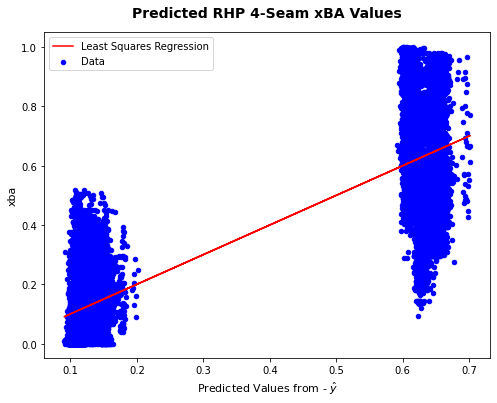

In [32]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_r, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_r, np.poly1d(np.polyfit(pred_ff_r, y, 1))(pred_ff_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xba', fontsize = 11)
plt.title('Predicted RHP 4-Seam xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

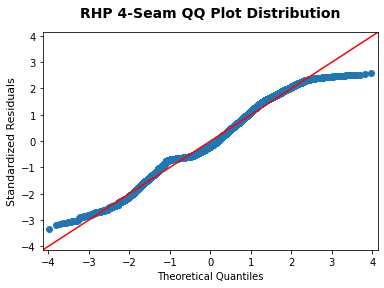

In [33]:
sm.qqplot(residuals_ff_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [34]:
X = X_ff_l.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_ff_l['xba']

ols_ff_l = sm.OLS(y, X).fit()
pred_ff_l = ols_ff_l.predict(X)
fitted_vals_ff_l = ols_ff_l.fittedvalues
residuals_ff_l = ols_ff_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_l), 4))
print(ols_ff_l.summary())

MSE: 0.025
RMSE: 0.1581
MAE: 0.1272
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     4423.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:00   Log-Likelihood:                 5066.3
No. Observations:               11900   AIC:                        -1.012e+04
Df Residuals:                   11892   BIC:                        -1.006e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------


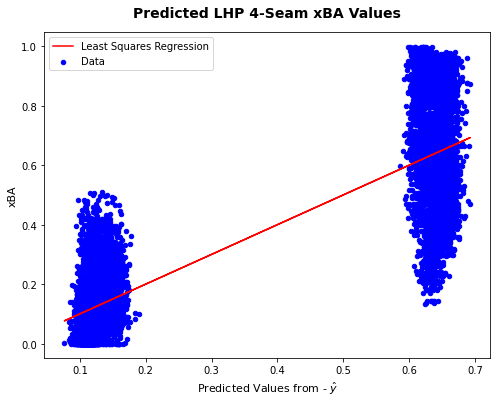

In [35]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_l, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_l, np.poly1d(np.polyfit(pred_ff_l, y, 1))(pred_ff_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted LHP 4-Seam xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

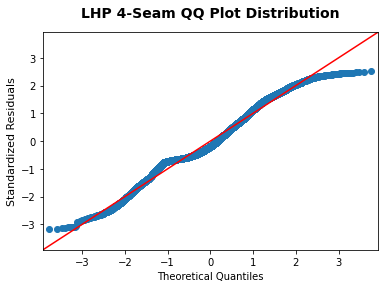

In [36]:
sm.qqplot(residuals_ff_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Cutter

### RHP

In [37]:
X = X_fc_r.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_fc_r['xba']

ols_fc_r = sm.OLS(y, X).fit()
pred_fc_r = ols_fc_r.predict(X)
fitted_vals_fc_r = ols_fc_r.fittedvalues
residuals_fc_r = ols_fc_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_r), 4))
print(ols_fc_r.summary())

MSE: 0.023
RMSE: 0.1516
MAE: 0.1221
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     2114.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:00   Log-Likelihood:                 2614.2
No. Observations:                5588   AIC:                            -5212.
Df Residuals:                    5580   BIC:                            -5159.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------


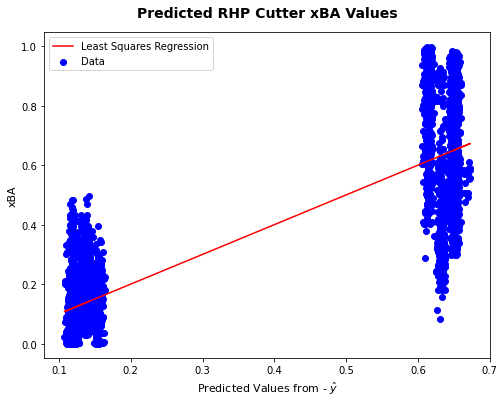

In [38]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_r, np.poly1d(np.polyfit(pred_fc_r, y, 1))(pred_fc_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted RHP Cutter xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

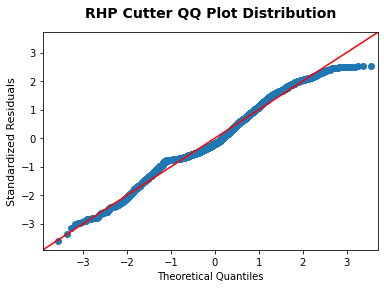

In [39]:
sm.qqplot(residuals_fc_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [40]:
X = X_fc_l.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_fc_l['xba']

ols_fc_l = sm.OLS(y, X).fit()
pred_fc_l = ols_fc_l.predict(X)
fitted_vals_fc_l = ols_fc_l.fittedvalues
residuals_fc_l = ols_fc_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_l), 4))
print(ols_fc_l.summary())

MSE: 0.0228
RMSE: 0.1511
MAE: 0.1219
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1184.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:00   Log-Likelihood:                 1464.0
No. Observations:                3110   AIC:                            -2912.
Df Residuals:                    3102   BIC:                            -2864.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

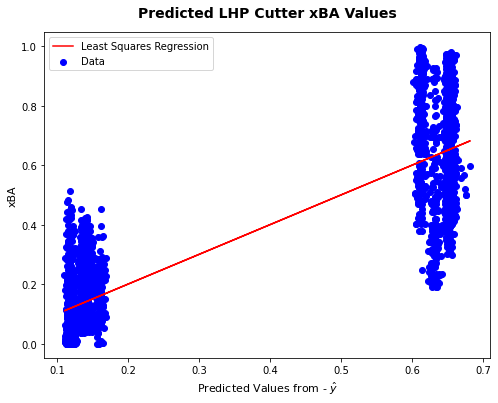

In [41]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_l, np.poly1d(np.polyfit(pred_fc_l, y, 1))(pred_fc_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted LHP Cutter xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

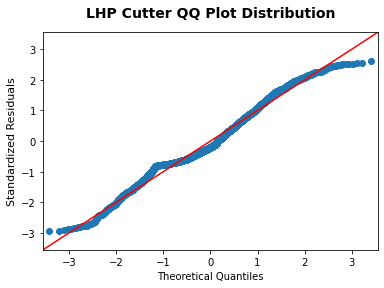

In [42]:
sm.qqplot(residuals_fc_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Sinker

### RHP

In [43]:
X = X_si_r.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_si_r['xba']

ols_si_r = sm.OLS(y, X).fit()
pred_si_r = ols_si_r.predict(X)
fitted_vals_si_r = ols_si_r.fittedvalues
residuals_si_r = ols_si_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_r), 4))
print(ols_si_r.summary())

MSE: 0.0212
RMSE: 0.1455
MAE: 0.1178
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     5676.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:01   Log-Likelihood:                 7822.0
No. Observations:               15373   AIC:                        -1.563e+04
Df Residuals:                   15365   BIC:                        -1.557e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

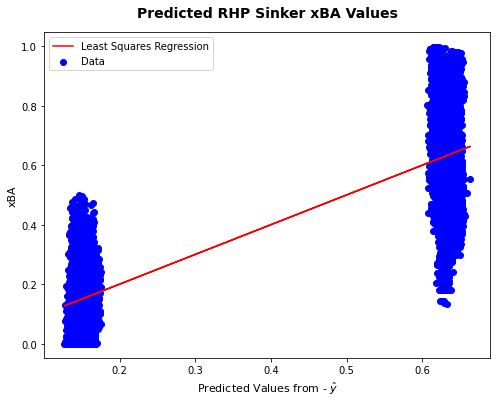

In [44]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_r, np.poly1d(np.polyfit(pred_si_r, y, 1))(pred_si_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted RHP Sinker xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

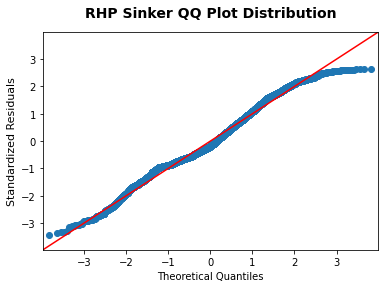

In [45]:
sm.qqplot(residuals_si_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [46]:
X = X_si_l.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_si_l['xba']

ols_si_l = sm.OLS(y, X).fit()
pred_si_l = ols_si_l.predict(X)
fitted_vals_si_l = ols_si_l.fittedvalues
residuals_si_l = ols_si_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_l), 4))
print(ols_si_l.summary())

MSE: 0.0216
RMSE: 0.1469
MAE: 0.119
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     2392.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:01   Log-Likelihood:                 3299.0
No. Observations:                6606   AIC:                            -6582.
Df Residuals:                    6598   BIC:                            -6528.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------


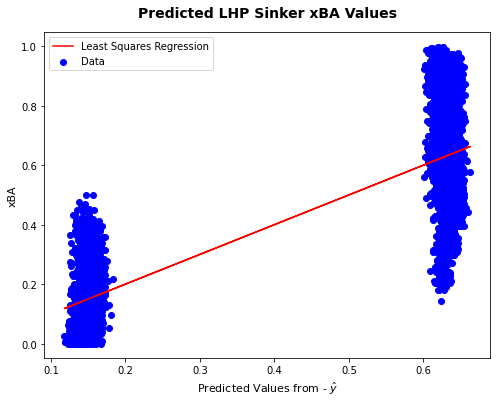

In [47]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_l, np.poly1d(np.polyfit(pred_si_l, y, 1))(pred_si_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted LHP Sinker xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

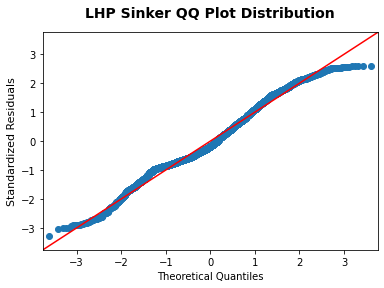

In [48]:
sm.qqplot(residuals_si_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Slider

### RHP

In [49]:
X = X_sl_r.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_sl_r['xba']

ols_sl_r = sm.OLS(y, X).fit()
pred_sl_r = ols_sl_r.predict(X)
fitted_vals_sl_r = ols_sl_r.fittedvalues
residuals_sl_r = ols_sl_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_r), 4))
print(ols_sl_r.summary())

MSE: 0.0224
RMSE: 0.1496
MAE: 0.1179
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     6314.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:01   Log-Likelihood:                 7770.4
No. Observations:               16153   AIC:                        -1.552e+04
Df Residuals:                   16145   BIC:                        -1.546e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

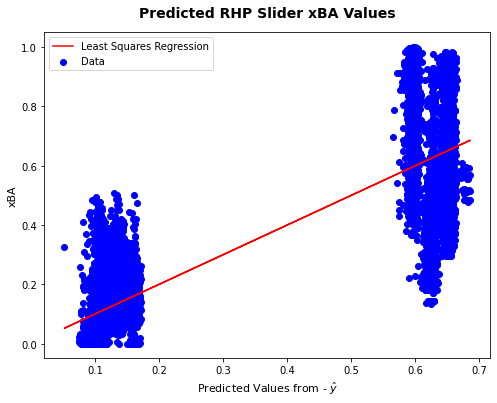

In [50]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_r, np.poly1d(np.polyfit(pred_sl_r, y, 1))(pred_sl_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted RHP Slider xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

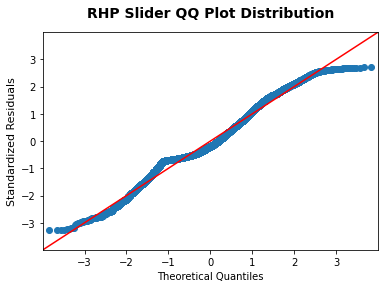

In [51]:
sm.qqplot(residuals_sl_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [52]:
X = X_sl_l.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_sl_l['xba']

ols_sl_l = sm.OLS(y, X).fit()
pred_sl_l = ols_sl_l.predict(X)
fitted_vals_sl_l = ols_sl_l.fittedvalues
residuals_sl_l = ols_sl_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_l), 4))
print(ols_sl_l.summary())

MSE: 0.0228
RMSE: 0.1509
MAE: 0.1202
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2080.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:02   Log-Likelihood:                 2531.6
No. Observations:                5365   AIC:                            -5047.
Df Residuals:                    5357   BIC:                            -4994.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

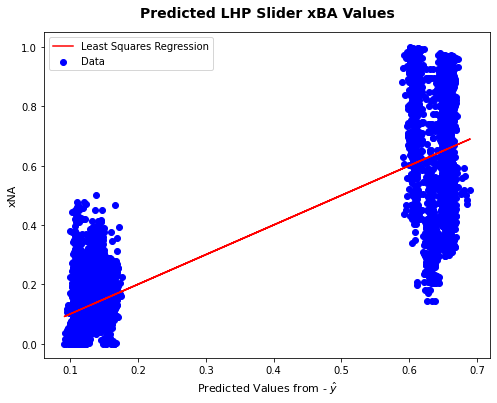

In [53]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_l, np.poly1d(np.polyfit(pred_sl_l, y, 1))(pred_sl_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xNA', fontsize = 11)
plt.title('Predicted LHP Slider xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

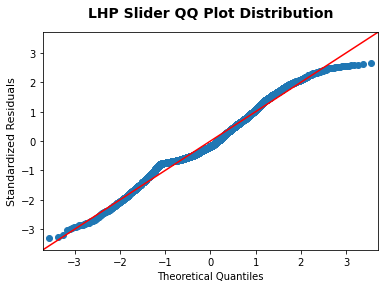

In [54]:
sm.qqplot(residuals_sl_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Curveball

### RHP

In [55]:
X = X_cu_r.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_cu_r['xba']

ols_cu_r = sm.OLS(y, X).fit()
pred_cu_r = ols_cu_r.predict(X)
fitted_vals_cu_r = ols_cu_r.fittedvalues
residuals_cu_r = ols_cu_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_r), 4))
print(ols_cu_r.summary())

MSE: 0.0222
RMSE: 0.1489
MAE: 0.1184
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     2222.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:02   Log-Likelihood:                 2786.6
No. Observations:                5743   AIC:                            -5557.
Df Residuals:                    5735   BIC:                            -5504.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

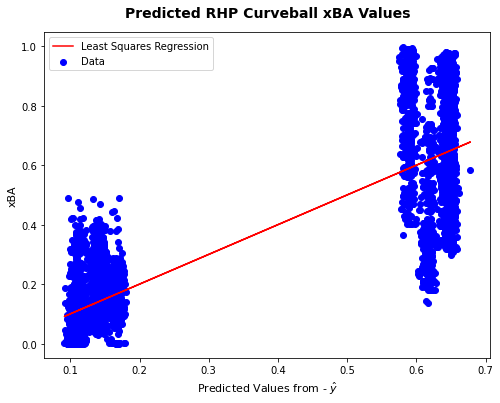

In [56]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_r, np.poly1d(np.polyfit(pred_cu_r, y, 1))(pred_cu_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted RHP Curveball xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

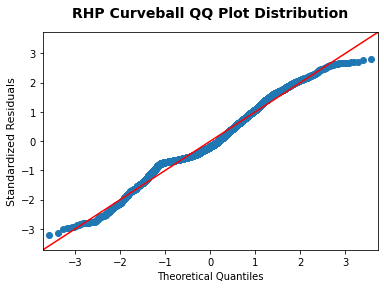

In [57]:
sm.qqplot(residuals_cu_r, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [58]:
X = X_cu_l.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_cu_l['xba']

ols_cu_l = sm.OLS(y, X).fit()
pred_cu_l = ols_cu_l.predict(X)
fitted_vals_cu_l = ols_cu_l.fittedvalues
residuals_cu_l = ols_cu_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_l), 4))
print(ols_cu_l.summary())

MSE: 0.0212
RMSE: 0.1457
MAE: 0.1155
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1139.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:02   Log-Likelihood:                 1368.0
No. Observations:                2696   AIC:                            -2720.
Df Residuals:                    2688   BIC:                            -2673.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

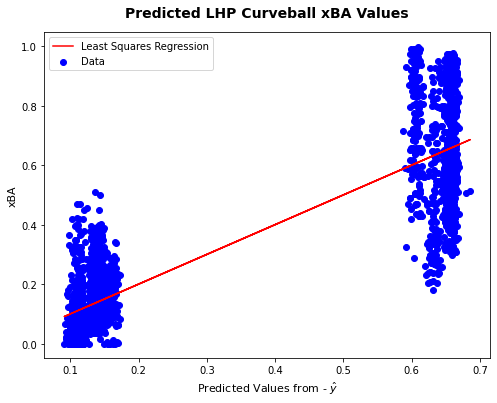

In [59]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_l, np.poly1d(np.polyfit(pred_cu_l, y, 1))(pred_cu_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted LHP Curveball xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

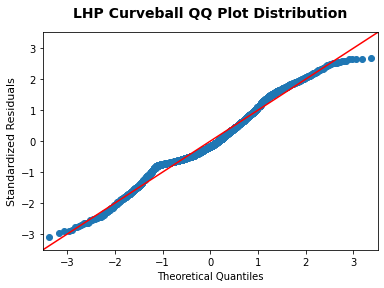

In [60]:
sm.qqplot(residuals_cu_l, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Changeup

### RHP

In [61]:
X = X_ch_r.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_ch_r['xba']

ols_ch_r = sm.OLS(y, X).fit()
pred_ch_r = ols_ch_r.predict(X)
fitted_vals_ch_r = ols_ch_r.fittedvalues
residuals_ch_r = ols_ch_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_r), 4))
print(ols_ch_r.summary())

MSE: 0.0406
RMSE: 0.2016
MAE: 0.1627
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     1296.
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:03   Log-Likelihood:                 1757.1
No. Observations:                9626   AIC:                            -3498.
Df Residuals:                    9618   BIC:                            -3441.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

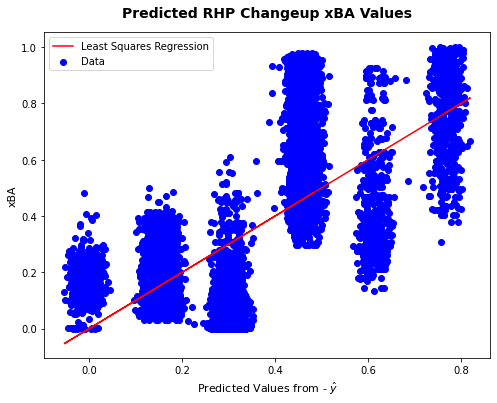

In [62]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_r, np.poly1d(np.polyfit(pred_ch_r, y, 1))(pred_ch_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted RHP Changeup xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

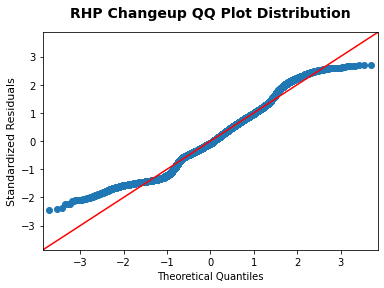

In [63]:
sm.qqplot(residuals_ch_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [64]:
X = X_ch_l.drop(columns = ['xba'])
X = sm.add_constant(X)
y = X_ch_l['xba']

ols_ch_l = sm.OLS(y, X).fit()
pred_ch_l = ols_ch_l.predict(X)
fitted_vals_ch_l = ols_ch_l.fittedvalues
residuals_ch_l = ols_ch_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_l), 4))
print(ols_ch_l.summary())

MSE: 0.0413
RMSE: 0.2033
MAE: 0.1643
                            OLS Regression Results                            
Dep. Variable:                    xba   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     824.6
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:09:03   Log-Likelihood:                 1088.2
No. Observations:                6251   AIC:                            -2160.
Df Residuals:                    6243   BIC:                            -2106.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

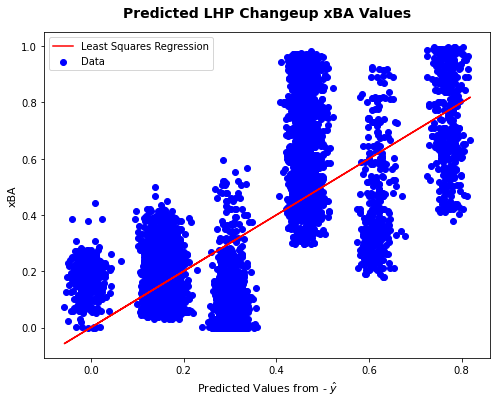

In [65]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_l, np.poly1d(np.polyfit(pred_ch_l, y, 1))(pred_ch_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xBA', fontsize = 11)
plt.title('Predicted LHP Changeup xBA Values', fontsize = 14, fontweight = 'bold', pad = 15);

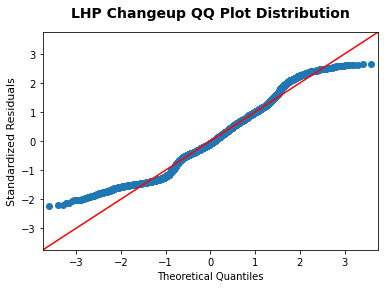

In [66]:
sm.qqplot(residuals_ch_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);